In [27]:
curr_dir = '/user_data/vayzenbe/GitHub_Repos/ginn'

import sys
sys.path.insert(1, f'{curr_dir}')
import numpy as np
import pandas as pd
import ginn_params as params
from scipy.stats import gamma
import matplotlib.pyplot as plt

In [33]:
vols = 93
fix_tr = params.fix_tr
tr = params.tr
fps = params.fps
bin_size = params.bin_size
data_dir = params.data_dir

In [22]:
def down_sample(data):
    """Downsample data"""
    downsample_ts = []
    
    #Bin frame data for TS
    for nn in range(0,len(data),bin_size):
        temp = data[nn:(nn+bin_size)]

        downsample_ts.append(np.mean(temp))

    downsample_ts = np.array(downsample_ts)
    downsample_ts = downsample_ts[0:(vols)] #extract only 168 volumes to match fmri data (credits of movie were cut)
    
    return downsample_ts

def hrf(data, tr):
    """ Return values for HRF at given times """
    times = np.arange(0, 30, tr)
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    hrf_at_trs = values / np.max(values) * 0.6 
    
    
    return np.convolve(data, hrf_at_trs)

# %%
def convolve_hrf(data):

    conv_ts =np.zeros((data.shape))

    temp = hrf(data[:],tr)
    temp = temp[0:(vols-fix_tr)] 
    #temp = (temp - np.mean(temp))/np.std(temp)
    conv_ts[:] = temp
        
    return conv_ts

In [23]:
#load cov data
cov = pd.read_csv(f'{curr_dir}/stim/fmri_videos/aeronaut_face_covs.csv')

In [24]:
#min-max scale proportion column
#add to new column
cov['prop_scaled'] = (cov['proportion'] - cov['proportion'].min())/(cov['proportion'].max() - cov['proportion'].min())


In [30]:
down_sample_data = down_sample(cov['present'].values)
#min max scale downsampled data
down_sample_data = (down_sample_data - down_sample_data.min())/(down_sample_data.max() - down_sample_data.min())

In [31]:
convolved_data = convolve_hrf(down_sample_data)

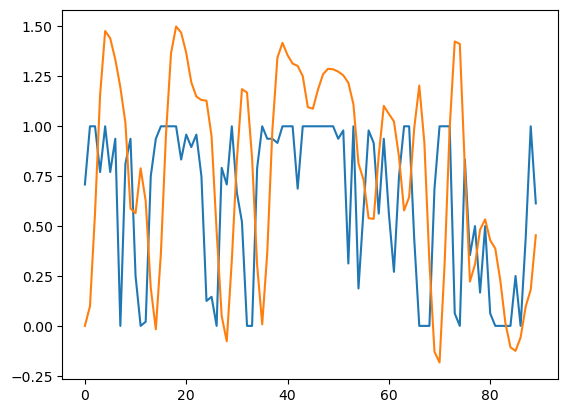

In [32]:
plt.plot(down_sample_data)
plt.plot(convolved_data)

In [29]:
#save convolved data
np.save(f'{curr_dir}/fmri/pre_proc/aeronaut_parametric_face_cov.npy',convolved_data)

In [63]:
#load fmri data 
roi_data = np.load(f'{data_dir}/sub-s1607_1_2/timeseries/lLO_ts_all.npy')
roi_data = roi_data[fix_tr:,:]
#remove cols with all zeros
roi_data = roi_data[:,~np.all(roi_data == 0, axis=0)]

In [64]:
#correlate each row of roi_data with convolved_data
corr = np.zeros((roi_data.shape[1],1))

for i in range(roi_data.shape[1]):
    corr[i] = np.corrcoef(roi_data[:,i],convolved_data)[0,1]

In [65]:
#extract indices of top 10% of voxels
top_10 = np.argsort(corr,axis=0)[-int(roi_data.shape[1]*0.1):]


(array([ 37., 103., 181., 238., 253., 217., 167., 157., 121.,  33.]),
 array([-0.31843818, -0.25583157, -0.19322495, -0.13061833, -0.06801171,
        -0.00540509,  0.05720153,  0.11980814,  0.18241476,  0.24502138,
         0.307628  ]),
 <BarContainer object of 10 artists>)

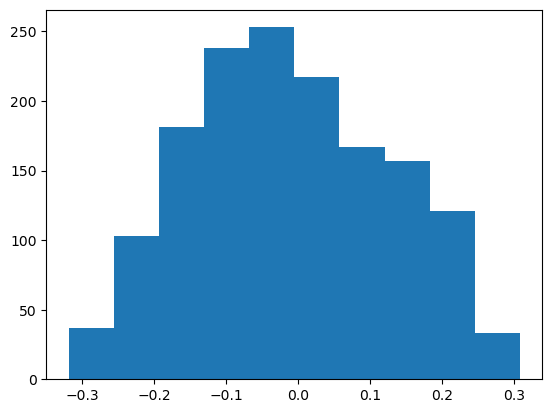

In [66]:
plt.hist(corr)